# Self Organized Maps (SOMs)

## Import Libraries

In [66]:
# MiniSOM
from minisom import MiniSom

# XPySOM
from xpysom import XPySom

# SimpSOM, https://simpsom.readthedocs.io
import simpsom as sps
# from simpsom.plots import scatter_on_map

# Math and others
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.table import Table

## Import catalog

In [53]:
emu_matched_catalog = '/home/polaris/Lab_Astro/data/cross_match/cm5/EMU_0102-32_DES_VIKING_CATWISE_mag_pany056.fits'

In [54]:
catalog_table = Table.read(emu_matched_catalog, format='fits')
catalog_df = catalog_table.to_pandas()

# Select the columns of interest
print(catalog_df.columns)
columns_of_interest = ['DES_mag_auto_g_dered', 'DES_mag_auto_r_dered', 'DES_mag_auto_i_dered', 'DES_mag_auto_z_dered',
                       'VKG_zPetroMag', 'VKG_jPetroMag', 'VKG_yPetroMag', 'VKG_ksPetroMag', 'VKG_hPetroMag', 'CAT_w1mpro', 'CAT_w2mpro']
catalog_df_filtered = catalog_df[columns_of_interest]


Index(['EMU_island_id', 'EMU_island_name', 'EMU_n_components',
       'EMU_ra_deg_cont', 'EMU_dec_deg_cont', 'EMU_freq', 'EMU_maj_axis',
       'EMU_min_axis', 'EMU_pos_ang', 'EMU_flux_int',
       ...
       'bias_DES_mag_auto_r_dered', 'bias_DES_mag_auto_i_dered',
       'bias_DES_mag_auto_z_dered', 'bias_DES_mag_auto_y_dered',
       'bias_CAT_w1mpro', 'bias_CAT_w2mpro', 'p_single', 'p_any', 'p_i',
       'match_flag'],
      dtype='object', length=105)


In [55]:
catalog_matrix = catalog_df_filtered.to_numpy()

## SimpSOM

In [71]:
from pylettes import *
pylette = Tundra(reverse=True).cmap

from keras.datasets import mnist
(train_X, train_y), (test_X, test_y) = mnist.load_data()

flat_data = train_X.reshape(train_X.shape[0], -1)

flat_data = train_X.reshape(train_X.shape[0], -1)

net = sps.SOMNet(10, 10, flat_data)

Periodic Boundary Conditions inactive.
The weights will be initialized with PCA.


In [72]:
net.train(train_algo='batch', start_learning_rate=0.01,
          epochs=-1, batch_size=-1)
net.save_map("/home/polaris/Lab_Astro/data/SOMs/trained_som_MNIST.npy")

The map will be trained with the batch algorithm.
Training SOM... 0% 

MemoryError: Unable to allocate 35.0 GiB for an array with shape (60000, 100, 784) and data type float64

In [ ]:
_ = net.plot_map_by_difference(show=True, print_out=True,
    cmap=pylette)

### XPySom

In [37]:
data_min = catalog_matrix.min(axis=0)
data_max = catalog_matrix.max(axis=0)
normalized_data = (catalog_matrix - data_min) / (data_max - data_min)

In [47]:
galaxy_names = catalog_df['EMU_island_name'].values

# data normalization
data = (catalog_df_filtered - np.mean(catalog_df_filtered, axis=0)) / np.std(catalog_df_filtered, axis=0)
data = data.values

# Initialization and training
som_shape = (20, 20)
som = XPySom(20, 20, data)


TypeError: only integer scalar arrays can be converted to a scalar index

## MiniSom

### Example

In [14]:
from minisom import MiniSom
import numpy as np
import pandas as pd

data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt', 
                    names=['area', 'perimeter', 'compactness', 'length_kernel', 'width_kernel',
                   'asymmetry_coefficient', 'length_kernel_groove', 'target'], usecols=[0, 5], 
                   sep='\t+', engine='python')
# data normalization
data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
data = data.values

# Initialization and training
som_shape = (1, 3)
som = MiniSom(som_shape[0], som_shape[1], data.shape[1], sigma=.5, learning_rate=.5,
              neighborhood_function='gaussian', random_seed=10)

som.train_batch(data, 500, verbose=True)

 [ 500 / 500 ] 100% - 0:00:00 left 
 quantization error: 0.846705446733947


In [15]:
# each neuron represents a cluster
winner_coordinates = np.array([som.winner(x) for x in data]).T
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)

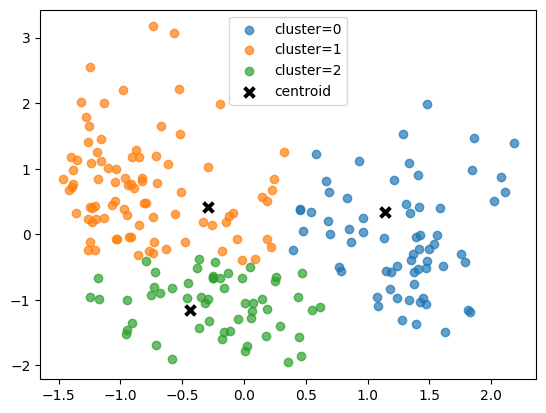

In [16]:
import matplotlib.pyplot as plt

# plotting the clusters using the first 2 dimentions of the data
for c in np.unique(cluster_index):
    plt.scatter(data[cluster_index == c, 0],
                data[cluster_index == c, 1], label='cluster='+str(c), alpha=.7)

# plotting centroids
for centroid in som.get_weights():
    plt.scatter(centroid[:, 0], centroid[:, 1], marker='x', 
                s=4, linewidths=10, color='k', label='centroid')
plt.legend(loc='best')

### With our galaxy values

In [32]:
galaxy_names = catalog_df_filtered['EMU_island_name'].values

# data normalization
data = (catalog_df_filtered - np.mean(catalog_df_filtered, axis=0)) / np.std(catalog_df_filtered, axis=0)
data = data.values

# Initialization and training
som_shape = (20, 20)
som = XPySom(som_shape[0], som_shape[1], data)

som.train(150)

KeyError: 'EMU_island_name'

In [29]:
# each neuron represents a cluster
winner_coordinates = np.array([som.winner(x) for x in data]).T
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)